In [1]:
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 29.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# **家庭所得階層、創業決策與階層流動：雙重機器學習（Double/Debiased Machine Learning）的取徑**


## **一、前言與文獻回顧**

本篇報告基於林祖嘉等學者（2020）的研究成果，利用臺灣社會變遷基本調查計畫第七期第三次「社會階層」主題資料集（傅仰止，2023），使用雙重機器學習方法，並提出適當的工具變項，進一步探討台灣社會的家庭所得階層及創業對所得階層流動的影響。

在林祖嘉等人（2020）的研究中，他們回顧了家庭對於兒女創業意願的關係。首先，許多研究表明家庭教育對於青年人的創業動機影響非常大，且一些研究也指出男性創業意願高於女性。另一方面，在台灣社會的背景下，近代的創業者由中高收入階層佔多數，逐漸取代早年因家庭貧困而出來創業的低收入階層，尤其在台灣社會，創業者初期資金來源多為周遭的親友，與前述的中高收入階層有著一定程度的關聯。過去的文獻也證實，過去工作累積下來的經驗與人脈，很大程度上能夠推動一個人的創業動機。

在個體層面，對於當下現狀（收入、工作挫折、工時）的不滿、個人追求（自我實現、社會責任、市場機會）等因素，亦是推動個人創業的因素。

另外，文章中也關心創業是否如學者以及政策所預期，認為創業為所得階層流動的重要管道，因此林祖嘉等人（2020）的研究中也有相關的討論。

## **二、研究問題與方法**

本篇報告挑選林祖嘉等學者研究中（2020）重要其中一個研究問題，在其基礎上進一步追問其因果效應（Caual Effect）。本篇報告想要回答的問題是：創業對家庭所得階層流動的因果效應為何？

綜合前述的回顧，我們將會設計一個模型，使用雙重機器學習來估計其因果效應。


### **模型設計**


模型變量如下，為了驗證創業本身對所得階層造成的影響，我們會同時考慮：

*   $X$ 為控制變量，包含如下變量
  * 受訪者的年齡
  * 性別
  * 受教育年數
  * 父親的工作型態
  * 居住地區（都會核心區、工商市區、新興市鎮、傳統產業市鎮、低度發展鄉鎮，或是高齡偏遠鄉鎮）
*   $Y$ 為調查當下個人的所得階層；
*   $T_{1}$ 為創業與否；
*   $T_{2}$ 為年少時期家庭所得階層；
*   $Z_1$ 為 $T_{1}$ 的工具變量，我們選用了以下兩個工具變量：
  * 一週工作天數
  * 工作平均收入
*   $Z_2$ 為 $T_{2}$ 的工具變量，我們選用了以下四個工具變量：
  * 父親教育年數
  * 對他人的信任程度（我們預期對他人越信任，說明成長過程更順遂）
  * 自評快樂程度
  * 自評健康程度
  
模型設計及因果路徑圖如下：

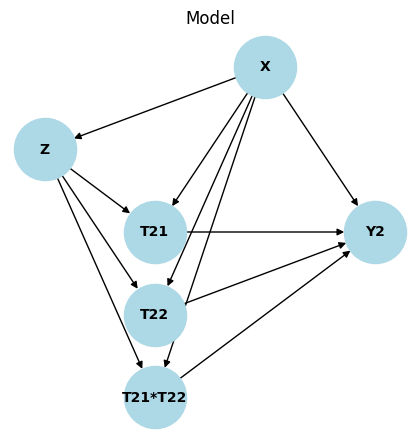

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.DiGraph()

a = 'X'
b = 'Y2'
c = 'T21'
d = 'Z'
e = 'T22'
f = 'T21*T22'

nodes = [a,b,c,d,e,f]
G.add_nodes_from(nodes)
edges = [(a,b),(a,c),(a,d),(a,e),(a,f),(c,b),(e,b),(f,b),(d,c),(d,e),(d,f)]
G.add_edges_from(edges)

pos = {a: (1, 2), b: (2, 1), c: (0, 1), d:(-1,1.5), e:(0,0.5), f:(0,0)}

plt.figure(figsize=(4, 4))

nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')

node_labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=node_labels)

plt.title("Model")
plt.axis('off')

plt.show()

## **三、資料處理與前置作業**

### **（一）資料集讀取與清洗**

本資料集取自台灣社會變遷基本調查計畫2017第七期第三次：社會階層組，由於僅提供STATA的.dta以及SPSS的資料檔，為簡化流程，大部分的資料清洗已在STATA中完成，並且僅導入清洗後的變項。

In [13]:
import pandas as pd
df = pd.read_csv('TSCS2017_cleaned.csv')
df.head()

,stratum2,f_job,age,edu,strata_young,strata_current,is_entrepreneur,f_edu,trust,health,happy,worktime,gender,income
0,新興市鎮,自行創業,67,6.0,3.0,1.0,0.0,NaN,0.0,2.0,2.0,6.0,0,6.0
1,新興市鎮,NaN,69,6.0,2.0,3.0,0.0,0.0,1.0,4.0,2.0,NaN,0,NaN
2,傳統產業市鎮,自行創業,52,14.0,4.0,4.0,1.0,6.0,3.0,3.0,2.0,7.0,1,9.0
3,工商市區,自行創業,41,12.0,3.0,3.0,1.0,6.0,1.0,2.0,3.0,7.0,1,0.0
4,傳統產業市鎮,NaN,64,9.0,1.0,1.0,0.0,NaN,NaN,4.0,1.0,5.0,0,6.0


In [14]:
df = df.dropna().reset_index(drop = True)
df.head()

,stratum2,f_job,age,edu,strata_young,strata_current,is_entrepreneur,f_edu,trust,health,happy,worktime,gender,income
0,傳統產業市鎮,自行創業,52,14.0,4.0,4.0,1.0,6.0,3.0,3.0,2.0,7.0,1,9.0
1,工商市區,自行創業,41,12.0,3.0,3.0,1.0,6.0,1.0,2.0,3.0,7.0,1,0.0
2,傳統產業市鎮,自行創業,61,9.0,2.0,3.0,0.0,6.0,1.0,2.0,3.0,5.0,0,7.0
3,傳統產業市鎮,自行創業,67,6.0,3.0,3.0,0.0,0.0,1.0,3.0,1.0,4.0,1,6.0
4,傳統產業市鎮,自行創業,62,6.0,3.0,2.0,1.0,0.0,0.0,3.0,2.0,2.0,1,4.0


In [15]:
df.shape

(1012, 14)

In [16]:
temp = pd.get_dummies(df[['stratum2','f_job']], dtype = float)
df = pd.concat([df, temp], axis=1)
df.head()

,stratum2,f_job,age,edu,strata_young,strata_current,is_entrepreneur,f_edu,trust,health,...,income,stratum2_低度發展鄉鎮,stratum2_傳統產業市鎮,stratum2_工商市區,stratum2_新興市鎮,stratum2_都會核心,f_job_公部門,f_job_無工作,f_job_私部門,f_job_自行創業
0,傳統產業市鎮,自行創業,52,14.0,4.0,4.0,1.0,6.0,3.0,3.0,...,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,工商市區,自行創業,41,12.0,3.0,3.0,1.0,6.0,1.0,2.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,傳統產業市鎮,自行創業,61,9.0,2.0,3.0,0.0,6.0,1.0,2.0,...,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,傳統產業市鎮,自行創業,67,6.0,3.0,3.0,0.0,0.0,1.0,3.0,...,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,傳統產業市鎮,自行創業,62,6.0,3.0,2.0,1.0,0.0,0.0,3.0,...,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### **（二）工具變量驗證**

一個合適的工具變量必須滿足相關性（Relevance）及外生性（Exogeniety）兩大條件，在這個情況下，相關性代表必須與兩個模型的 $T$ 有足夠強的相關性；外生性代表其與誤差項（error term）不能有任何相關。

IV的相關性驗證如下：

In [62]:
Controls = ['stratum2_低度發展鄉鎮', 'stratum2_傳統產業市鎮', 'stratum2_新興市鎮', 'stratum2_工商市區', 'stratum2_都會核心',
     'f_job_公部門','f_job_私部門', 'f_job_自行創業', 'f_job_無工作','age','edu','gender']
Y1 = 'strata_current'
T1 = 'strata_young'
T2 = 'is_entrepreneur'
Z1 = ['f_edu','trust','happy']
Z2 = ['worktime','income']

In [63]:
import statsmodels.api as sm
Y = df[Y1]
T1 = df[T1]
T2 = df[T2]
Z = df[Z1+Z2]
X = df[Controls]

# IV + Controls
IVs = pd.concat([Z, X], axis=1)

# Regress T1 on IV & Controls
first_stage = sm.OLS(T1, sm.add_constant(IVs)).fit()
T1_hat = first_stage.predict(sm.add_constant(IVs))

# F-test
f_test = first_stage.f_test(' + '.join(Z1+Z2) + ' = 0')
print(f_test.summary())

<F test: F=18.48924560396811, p=1.876652545206585e-05, df_denom=996, df_num=1>


$$
H_0: \beta_{\text{f_edu}} = \beta_{\text{trust}} = \beta_{\text{happy}} = \beta_{\text{worktime}} = \beta_{\text{income}} = 0 \\
F = 17.32, p \approx 0
\\
\text{拒絕 $H_0$，我們有足夠的證據說明這些IV符合Relevance條件。}
$$

In [64]:
# Regress T2 on IV & Controls
first_stage = sm.OLS(T2, sm.add_constant(IVs)).fit()
T2_hat = first_stage.predict(sm.add_constant(IVs))

# F-test
f_test = first_stage.f_test(' + '.join(Z1+Z2) + ' = 0')
print(f_test.summary())

<F test: F=42.04400514928525, p=1.4024816452415174e-10, df_denom=996, df_num=1>


$$
H_0: \beta_{\text{f_edu}} = \beta_{\text{trust}} = \beta_{\text{happy}} = \beta_{\text{worktime}} = \beta_{\text{income}} = 0 \\
F = 44.275, p \approx 0
\\
\text{拒絕 $H_0$，我們有足夠的證據說明這些IV符合Relevance條件。}
$$

### **（三）機器學習模型挑選**

候選ML模型如下：Linear Regression, Lasso Regression, Ridge Regression, SVR, Decision Tree, Random Forest Regression, Gradient Bossting Regression. 我們利用MSE作為判斷指標，評估模型預設表現，並為表現最好的模型調整參數。

根據DoubleML官方的介紹（https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLIV.html ），一個含有工具變量的模型需要輸入三個ML模型，分別處理三個nuisance function：


1.   `ml_l`: $\ell_0(X) = E[Y | X]$
2.   `ml_m`: $m_0(X) = E[Z | X]$
3.   `ml_r`: $r_0(X) = E[D | X]$


因此，我們首先應該篩選最適合的三個模型。

##### 首先挑選`ml_l`的模型：

In [ ]:
Controls = ['stratum2_低度發展鄉鎮', 'stratum2_傳統產業市鎮', 'stratum2_新興市鎮', 'stratum2_工商市區', 'stratum2_都會核心',
     'f_job_公部門','f_job_私部門', 'f_job_自行創業', 'f_job_無工作','age','edu','gender']
Y1 = 'strata_current'
T1 = 'strata_young'
T2 = 'is_entrepreneur'
Z1 = ['f_edu','trust','happy']
Z2 = ['worktime','income']
df['T1T2'] = df[T1]*df[T2]

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

Y = df[Y1]
X = df[Controls]

models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor()
]

model_names = [
    "Linear Regression",
    "Lasso Regression",
    "Ridge Regression",
    "Support Vector Regression",
    "Decision Tree Regression",
    "Random Forest Regression",
    "Gradient Boosting Regression"
]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for model, name in zip(models, model_names):
    mse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        model.fit(X_train, Y_train)  # 訓練模型
        Y_pred = model.predict(X_test)  # 預測
        mse = mean_squared_error(Y_test, Y_pred)  # 計算 MSE
        mse_scores.append(mse)

    avg_mse = np.mean(mse_scores)  # 計算平均 MSE
    print(f"{name} Average MSE: {avg_mse}")

Linear Regression Average MSE: 0.6108475082627703
Lasso Regression Average MSE: 0.6855060303568834
Ridge Regression Average MSE: 0.6106899115807071
Support Vector Regression Average MSE: 0.6649528268967251
Decision Tree Regression Average MSE: 1.2870147729058619
Random Forest Regression Average MSE: 0.7812805517644386
Gradient Boosting Regression Average MSE: 0.6640361214929005


Lasso Regressor為最佳的模型，為Lasso Regressor調整參數，先確定參數大致範圍，再進一步細調：

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# 初始化 Lasso Regressor
lasso = Lasso()

# 使用 GridSearchCV 尋找最佳參數
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, Y)

# 印出最佳參數
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'alpha': 0.01}


In [ ]:
param_grid = {
    'alpha': np.arange(0.001, 0.011, 0.01)
}

# 初始化 Lasso Regressor
lasso = Lasso()

# 使用 GridSearchCV 尋找最佳參數
grid_search = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, Y)

# 印出最佳參數
print("Best Parameters:", grid_search.best_params_['alpha'])

Best Parameters: 0.001


In [ ]:
ml_l_lasso = Lasso(alpha=0.001)

# MSE
ml_l_lasso.fit(X, Y)
Y_hat = ml_l_lasso.predict(X)
mse_lasso = mean_squared_error(Y, Y_hat)
print("Lasso Regression MSE with best parameter:", mse_lasso)

Lasso Regression MSE with best parameter: 0.5981209331801444


##### 接下來挑選`ml_m`的模型：

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
X = df[Controls]
Y = pd.concat([df[T1], df[T2], df['T1T2']], axis=1)

models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    MultiOutputRegressor(SVR()),
    MultiOutputRegressor(DecisionTreeRegressor()),
    MultiOutputRegressor(RandomForestRegressor()),
    MultiOutputRegressor(GradientBoostingRegressor())
]

for model, name in zip(models, model_names):
    mse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        model.fit(X_train, Y_train)  # 訓練模型
        Y_pred = model.predict(X_test)  # 預測
        mse = mean_squared_error(Y_test, Y_pred)  # 計算 MSE
        mse_scores.append(mse)

    avg_mse = np.mean(mse_scores)  # 計算平均 MSE
    print(f"{name} Average MSE: {avg_mse}")

Linear Regression Average MSE: 0.7965795377367939
Lasso Regression Average MSE: 0.830752778129144
Ridge Regression Average MSE: 0.796337756751414
Support Vector Regression Average MSE: 0.8864706687451852
Decision Tree Regression Average MSE: 1.6099078544964514
Random Forest Regression Average MSE: 0.949149061934541
Gradient Boosting Regression Average MSE: 0.8396037673412481


整體而言，Ridge的表現最佳，調整參數：

In [ ]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# 初始化 Lasso Regressor
ridge = Ridge()

# 使用 GridSearchCV 尋找最佳參數
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, Y)

# 印出最佳參數
print("Best Parameters:", grid_search.best_params_['alpha'])

Best Parameters: 100


按照大致範圍，繼續搜索具體的最佳參數

In [ ]:
param_grid = {
    'alpha': range(50,300,1)
}

# 初始化 Lasso Regressor
ridge = Ridge()

# 使用 GridSearchCV 尋找最佳參數
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, Y)

# 印出最佳參數
print("Best Parameters:", grid_search.best_params_['alpha'])

Best Parameters: 70


...再進一步細調

In [ ]:
param_grid = {
    'alpha': np.arange(70,80,0.1)
}

# 初始化 Lasso Regressor
ridge = Ridge()

# 使用 GridSearchCV 尋找最佳參數
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, Y)

# 印出最佳參數
print("Best Parameters:", grid_search.best_params_['alpha'])

Best Parameters: 70.1


In [ ]:
ml_m_ridge = Ridge(alpha=70.1)

# MSE
ml_m_ridge.fit(X, Y)
Y_hat = ml_m_ridge.predict(X)
mse_lasso = mean_squared_error(Y, Y_hat)
print("Ridge Regression MSE with best parameter:", mse_lasso)

Ridge Regression MSE with best parameter: 0.7788104471540026


##### 最後挑選`ml_r`的模型：

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
X = df[Controls]
Y = df[Z1+Z2]

models = [
    LinearRegression(),
    Lasso(),
    Ridge(),
    MultiOutputRegressor(SVR()),
    MultiOutputRegressor(DecisionTreeRegressor()),
    MultiOutputRegressor(RandomForestRegressor()),
    MultiOutputRegressor(GradientBoostingRegressor())
]

for model, name in zip(models, model_names):
    mse_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        model.fit(X_train, Y_train)  # 訓練模型
        Y_pred = model.predict(X_test)  # 預測
        mse = mean_squared_error(Y_test, Y_pred)  # 計算 MSE
        mse_scores.append(mse)

    avg_mse = np.mean(mse_scores)  # 計算平均 MSE
    print(f"{name} Average MSE: {avg_mse}")

Linear Regression Average MSE: 6.821811230225416
Lasso Regression Average MSE: 7.165074942798237
Ridge Regression Average MSE: 6.820221224691551
Support Vector Regression Average MSE: 7.656936712090302
Decision Tree Regression Average MSE: 13.386068580207773
Random Forest Regression Average MSE: 7.904988771297977
Gradient Boosting Regression Average MSE: 6.9865319300533475


整體而言，Ridge的表現最佳，但鑒於前面的經驗，可以順便嘗試調GBR的參數。

In [ ]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# 初始化 Lasso Regressor
ridge = Ridge()

# 使用 GridSearchCV 尋找最佳參數
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, Y)

# 印出最佳參數
print("Best Parameters:", grid_search.best_params_['alpha'])

Best Parameters: 10


按照大致範圍，繼續搜索具體的最佳參數

In [ ]:
param_grid = {
    'alpha': range(1,20,1)
}

# 初始化 Lasso Regressor
ridge = Ridge()

# 使用 GridSearchCV 尋找最佳參數
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, Y)

# 印出最佳參數
print("Best Parameters:", grid_search.best_params_['alpha'])

Best Parameters: 19


...再進一步細調

In [ ]:
param_grid = {
    'alpha': np.arange(15,25,0.1)
}

# 初始化 Lasso Regressor
ridge = Ridge()

# 使用 GridSearchCV 尋找最佳參數
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, Y)

# 印出最佳參數
print("Best Parameters:", grid_search.best_params_['alpha'])

Best Parameters: 24.899999999999963


In [ ]:
ml_r_ridge = Ridge(alpha=24.9)

# MSE
ml_r_ridge.fit(X, Y)
Y_hat = ml_r_ridge.predict(X)
mse_lasso = mean_squared_error(Y, Y_hat)
print("Ridge Regression MSE with best parameter:", mse_lasso)

Ridge Regression MSE with best parameter: 6.62012924477511


### **（四）Double Machine Learning!**

將上面訓練出來的模型套入`doubleml`套件中的DMLIV。


In [ ]:
!pip install doubleml

In [ ]:
Controls = ['stratum2_低度發展鄉鎮', 'stratum2_傳統產業市鎮', 'stratum2_新興市鎮', 'stratum2_工商市區', 'stratum2_都會核心',
     'f_job_公部門','f_job_私部門', 'f_job_自行創業', 'f_job_無工作','age','edu','gender']
Y1 = 'strata_current'
T1 = 'strata_young'
T2 = 'is_entrepreneur'
Z1 = Z1
Z2 = ['worktime','income']
df['T1T2'] = df[T1]*df[T2]

In [ ]:
import doubleml as dml
obj_dml_data = dml.DoubleMLData(df,
                                y_col = Y1,
                                d_cols = [T1,T2,'T1T2'],
                                x_cols = Controls,
                                z_cols= Z1 + Z2)

dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, ml_l = ml_l_lasso, ml_m = ml_m_ridge, ml_r = ml_r_ridge)

dml_pliv_obj.fit().summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
strata_young,0.604955,0.127169,4.757079,0.000002,0.355707,0.854203
is_entrepreneur,-9.660493,4.182702,-2.309630,0.020909,-17.858438,-1.462548
T1T2,0.900393,0.342295,2.630461,0.008527,0.229508,1.571279


## **五、結論與討論**

本篇報告在林祖嘉等學者（2020）的研究基礎上，將一系列的工具變量（IV）納入Double ML進行分析，以進一步分析文章中最重要的問題，即「創業與否及家庭所得階層對於階層流動的影響為何」，並試圖從中估計其因果效應（Causal Effect）。

從雙重機器學習的統計結果中我們可以看到，$\beta_{\text{strata_young}}$、$\beta_{\text{is_entrepreneur}}$及兩者的交叉項$\beta_{\text{strata_young*is_entrepreneur}}$的P-value都非常小，在95%信心水準（$\alpha = 95\%$）下，有充分的證據說明他們的Causal Effect顯著不為0。

其中，$\beta_{\text{strata_young}}=0.605$，與林祖嘉等學者（2020）的研究結論類似，說明來自所得階層越高的人，成年後更有可能保持在較高的所得階層，這個部分解釋了階級複製的效果。

而是否為創業者及其交叉項目，在林祖嘉等學者（2020）的研究中的結論是：一方面，創業能夠提高所得階層（在文章中，創業的係數為正）；另一方面，創業對於所得階層的複製具有抑制作用（在他們的文章中，交互項的係數為負）。

然而，以DoubleML的分析結果來看，我們卻能夠注意到與上述完全相反的效果。從其Causal Effect來看，整體而言，創業會使得收入階層往下流動；而交叉項的係數則說明，年輕時期收入階層越高的人則會減緩創業帶來的向下流動幅度，並不支持林祖嘉等學者（2020）的觀點，認為創業對於階層複製具有抑制的作用，相反，研究結果顯示，年輕時所得階層越高的人，能夠為他們創業帶來更大的收入流動。



## 六、Reference

林祖嘉、李明軒、林姵宜（2020）。家庭所得階層對創業決策影響之研究－臺灣社會變遷調查資料的實證分析。人文及社會科學集刊，32(1)，39-79。https://www.airitilibrary.com/Article/Detail?DocID=1018189X-202003-202004270003-202004270003-39-79

傅仰止(2023)。臺灣社會變遷基本調查計畫2017第七期第三次：社會階層組(C00339_1)【原始數據】取自中央研究院人文社會科學研究中心調查研究專題中心學術調查研究資料庫。https://doi.org/10.6141/TW-SRDA-C00339_1-3

Feyzollahi, Maryam and Rafizadeh, Nima, Double/Debiased Machine Learning for Economists: Practical Guidelines, Best Practices, and Common Pitfalls (January 23, 2024). Available at SSRN: https://ssrn.com/abstract=4703243 or http://dx.doi.org/10.2139/ssrn.4703243

In [ ]:
%%shell
jupyter nbconvert --to html /content/causal_ml_final.ipynb

[NbConvertApp] Converting notebook /content/causal_ml_final.ipynb to html
[NbConvertApp] Writing 737150 bytes to /content/causal_ml_final.html
